# DETOXIFICATION



*   Miguel González García
*   Álvaro Fraile Carmena

Repositorio en [Github](https://github.com/18mgdev/nlp_detox).



## Imports y dependencias

In [1]:
%pip install -q torch
%pip install -q transformers[torch]
%pip install -q googletrans==3.1.0a0
%pip install -q fastparquet
%pip install sentencepiece
%pip install sacrebleu

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.1.143 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
openai 1.54.4 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 M

In [47]:
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from googletrans import Translator
from transformers import Trainer, TrainingArguments, T5Tokenizer, BartTokenizer, T5ForConditionalGeneration,BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, pipeline
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sacrebleu import CHRF
from tqdm.auto import trange
from typing import Optional, List, Dict, Union, Callable, Tuple
from functools import partial
from scipy.spatial.distance import cosine
import numpy.typing as npt
from transformers import TrainerCallback
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Preparación del dataset

### Lectura de datos

Vamos a leer el dataset de entrenamiento. Este dataset esta formado por 400 frases tóxicas por idioma en 9 idiomas diferentes y sus versiones no tóxicas. Además hemos añadido un dataset extra con ~19.000 frases en ingles. Formaremos un dataset conjunto que contenga para cada frase, su idioma de origen, la frase tóxica y la frase de-toxificada.

In [ ]:
splits = {'en': 'data/en-00000-of-00001.parquet', 'ru': 'data/ru-00000-of-00001.parquet', 'uk': 'data/uk-00000-of-00001.parquet', 'de': 'data/de-00000-of-00001.parquet', 'es': 'data/es-00000-of-00001.parquet', 'am': 'data/am-00000-of-00001.parquet', 'zh': 'data/zh-00000-of-00001.parquet', 'ar': 'data/ar-00000-of-00001.parquet', 'hi': 'data/hi-00000-of-00001.parquet'}
df_en = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["en"])
df_uk = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["uk"])
df_ru = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["ru"])
df_de = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["de"])
df_es = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["es"])
df_am = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["am"])
df_zh = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["zh"])
df_ar = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["ar"])
df_hi = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["hi"])

df_paradetox = pd.read_csv("hf://datasets/s-nlp/paradetox/train.tsv", sep="\t")
df_paradetox.rename(columns={"en_toxic_comment":"toxic_sentence", "en_neutral_comment":"neutral_sentence"}, inplace=True)

df_total = pd.concat([df_en, df_uk, df_ru, df_de, df_es, df_am, df_zh, df_ar, df_hi, df_paradetox], keys=['en','uk', 'ru', 'de', 'es', 'am', 'zh-cn', 'ar', 'hi', 'en']).reset_index(level=[0])
df_total.rename(columns={"level_0":"source_language", "toxic_sentence":"toxic_sentence", "neutral_sentence":"neutral_sentence"}, inplace=True)
df_total.sample(5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,source_language,toxic_sentence,neutral_sentence
8261,en,hold the mother fuckin phones,Hold the phones.
837,en,maybe blacks should be thankful for their good...,maybe black people should be thankful for thei...
17838,en,even that title is a shit post .,Even that title is a joke.
3177,en,either one is a fools errand .,either one is a waste of time .
18663,en,that 's where the fucking plane is .,that’s where the plane is .


## Arquitectura

Para la arquitectura de nuestro sistema de detoxificación vamos a seguir una de las baselines propuestas por PAN. La basesile de backtranslation sugiere crear un sistema de traducción y un sistema de detoxificación de un único idioma X.

Dada una entrada en un idioma Y, el sistema de traducción generar la traducción de la entrada al idioma X. Esta traducción será detoxificada por el sistema de detoxificación. La salidad detoxificada en el idioma X será *retrotraducida* al idioma original Y por el sistema de traducción y obtendremos el output final del sistema.




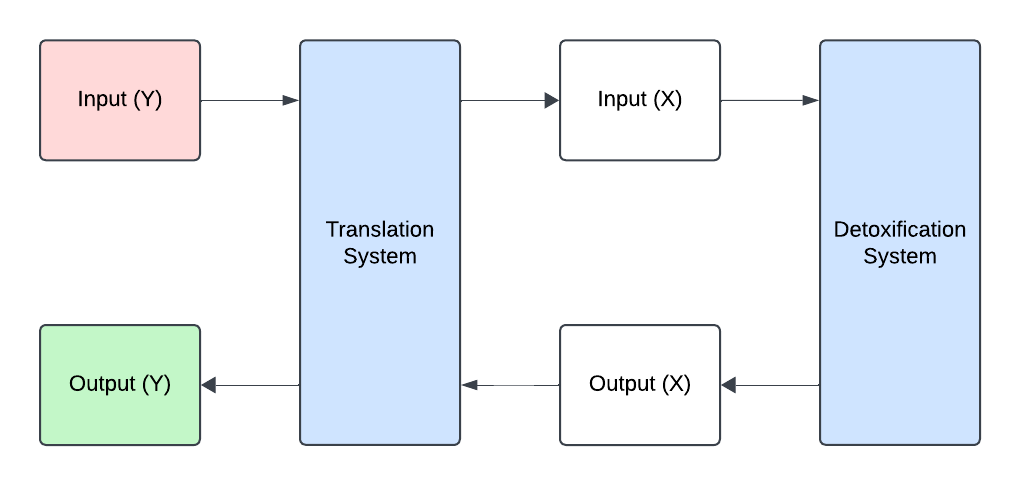

## Traducción


### Aproximación 1 - Google translate

Nuestra primera aproximación para este problema es utilizar la librería de Google Translate, la cual nos permite traducir todos los idiomas del dataset sin necesidad de grandes recursos computacionales.

In [19]:
translator = Translator()

def translate(text, source_lang, dest_lang):
    if source_lang == dest_lang:
        return text

    sol = translator.translate(text , src = source_lang, dest=dest_lang).text
    return sol

In [ ]:
df_numpy = df_total.to_numpy()

In [ ]:
toxic_translations = []
neutral_translations = []

for sentence in tqdm(df_numpy):
  toxic_translations.append(translate(sentence[1], sentence[0], 'en'))
  neutral_translations.append(translate(sentence[2], sentence[0], 'en'))


df_total["toxic_sentence_en"] = toxic_translations
df_total["neutral_sentence_en"] = neutral_translations

100%|██████████| 23344/23344 [05:11<00:00, 75.05it/s] 


In [ ]:
df_total.sample(3)

,source_language,toxic_sentence,neutral_sentence,toxic_sentence_en,neutral_sentence_en
8458,en,i like skinny tops & unbuttoned cover - all sh...,i like skinny tops & unbuttoned cover - all sh...,i like skinny tops & unbuttoned cover - all sh...,i like skinny tops & unbuttoned cover - all sh...
8915,en,you tweeting weird shit ! ! lol,You are tweeting weird stuff,you tweeting weird shit ! ! lol,You are tweeting weird stuff
67,ar,مضحك جداً أمر بعض الوافدين ومن ضمنهم مصاروة ! ...,مضحك جداً أمر بعض الوافدين ومن ضمنهم مصريين! ي...,"It's very funny about some of the expatriates,...","Very funny about some expatriates, including E..."


In [ ]:
df_total.to_csv("./translated_sentences_google_translate.csv")

### Aproximación 2 - facebook/m2m100_418M

La segunda aproximación consiste en usar un modelo transformer para la traducción. Analizando los idiomas que debemos traducir probamos a usar los siguientes modelos:



*   facebook/m2m100_418M
*   facebook/nllb-200-distilled-600M

Finalmente por los resultados, nos quedamos por el primero de los dos.



In [ ]:
# Inicializar listas para las traducciones
toxic_translations = []
neutral_translations = []

# Tamaño de batch para la traducción
batch_size = 400

for language in df_total["source_language"].unique():
    print(f"Translating sentences from {language}")
    df_language = df_total[df_total["source_language"] == language]
    toxic_sentences = df_language["toxic_sentence"].tolist()
    neutral_sentences = df_language["neutral_sentence"].tolist()

    # Si el idioma es diferente de inglés, se traduce del idioma origen al inglés
    if language != "en":
        # Configurar el pipeline con el idioma de origen y destino
        if(language=="zh-cn"):
          parsed_language = "zh"
        else:
          parsed_language = language

        translation_pipeline = pipeline(
            f"translation_{parsed_language}_to_en",  # La forma estándar para especificar los idiomas
            model="facebook/m2m100_418M",
            device=0,
            framework="pt",  # Asegúrate de usar PyTorch
            torch_dtype=torch.float16
        )

        # Crear lotes de toxic_sentences
        for i in range(0, len(toxic_sentences), batch_size):
            batch_toxic = toxic_sentences[i:i + batch_size]
            batch_neutral = neutral_sentences[i:i + batch_size]

            # Traducción en batches especificando el idioma origen y destino
            toxic_results = translation_pipeline(batch_toxic)
            neutral_results = translation_pipeline(batch_neutral)

            # Guardar solo las traducciones en las listas
            toxic_translations.extend([result["translation_text"] for result in toxic_results])
            neutral_translations.extend([result["translation_text"] for result in neutral_results])
    else:
        # Si el idioma es inglés, simplemente añades las frases originales
        toxic_translations.extend(toxic_sentences)
        neutral_translations.extend(neutral_sentences)

    # Asegúrate de que las longitudes coincidan
    if len(toxic_translations) == len(df_language):
        df_total.loc[df_total["source_language"] == language, "toxic_sentence_en"] = toxic_translations
    else:
        print(f"Length mismatch for toxic translations in {language}")

    if len(neutral_translations) == len(df_language):
        df_total.loc[df_total["source_language"] == language, "neutral_sentence_en"] = neutral_translations
    else:
        print(f"Length mismatch for neutral translations in {language}")

    # Reiniciar las listas de traducciones para el siguiente idioma
    toxic_translations = []
    neutral_translations = []


Translating sentences from en
Translating sentences from uk
Translating sentences from ru
Translating sentences from de
Translating sentences from es
Translating sentences from am
Translating sentences from zh-cn
Translating sentences from ar
Translating sentences from hi


In [ ]:
df_total.sample(5)

,source_language,toxic_sentence,neutral_sentence,toxic_sentence_en,neutral_sentence_en
3344,en,"to state it mildly , i am apoplectically angry...","To state it muldly , i am apoplecticlly angry ...","to state it mildly , i am apoplectically angry...","To state it muldly , i am apoplecticlly angry ..."
6138,en,i need to take my ass to sleep so im well rest...,I need to sleep so to be prepared for tomorrow...,i need to take my ass to sleep so im well rest...,I need to sleep so to be prepared for tomorrow...
7674,en,no shit ! ! rolls eyesyes i want to,I just really want to,no shit ! ! rolls eyesyes i want to,I just really want to
13007,en,what will it take to fix this shit ?,What will it take to fix this?,what will it take to fix this shit ?,What will it take to fix this?
8628,en,awh shit me too mhm lol so what you watching ?...,Aww me too haha so what are you watching? I fe...,awh shit me too mhm lol so what you watching ?...,Aww me too haha so what are you watching? I fe...


In [ ]:
df_total.to_csv("./translated_sentences_m2m100.csv")

### Comparación

Vamos a ver algunos ejemplos de las traducciones desde el español para elegir que aproximación elegimos. Hemos guardado los resultados de ambas aproximaciones a ficheros csv para evitar repetir todo el proceso.

In [ ]:
import random

In [ ]:
df_google_translate = pd.read_csv("./translated_sentences_google_translate.csv")
df_transformer = pd.read_csv("./translated_sentences_m2m100.csv")

In [ ]:
num_examples = 5
lenght = df_google_translate[df_google_translate['source_language'] == "es"].shape[0]

for example in range(num_examples):
  idx = random.randint(0, lenght - 1)
  print(f"FRASE ORIGINAL: {df_google_translate[df_google_translate['source_language'] == 'es'].iloc[idx]['toxic_sentence']}")
  print(f"TRADUCCIÓN GOOGLE TRANSLATE: {df_google_translate[df_google_translate['source_language'] == 'es'].iloc[idx]['toxic_sentence_en']}")
  print(f"TRADUCCIÓN TRANSFORMER: {df_transformer[df_transformer['source_language'] == 'es'].iloc[idx]['toxic_sentence_en']}")
  print("-" * 100)

FRASE ORIGINAL: pero este tio es un puto subnormal, o que le pasa?
TRADUCCIÓN GOOGLE TRANSLATE: but this guy is a fucking moron, or what's wrong with him?
TRADUCCIÓN TRANSFORMER: But this uncle is a subnormal pudding, or what happens to him?
----------------------------------------------------------------------------------------------------
FRASE ORIGINAL: Los centros de menores no tutelados son escuelas de delincuentes. 
TRADUCCIÓN GOOGLE TRANSLATE: Centers for unattended minors are schools for delinquents.
TRADUCCIÓN TRANSFORMER: Untouched children’s centres are criminals’ schools.
----------------------------------------------------------------------------------------------------
FRASE ORIGINAL: Jueves con J de mierda
TRADUCCIÓN GOOGLE TRANSLATE: Thursday with fucking J
TRADUCCIÓN TRANSFORMER: Thursday with J
----------------------------------------------------------------------------------------------------
FRASE ORIGINAL: Si los ladrones y golpistas de izquierda no le hubieran hec

Como podemos ver en los ejemplos, la traducción usando Google Translate contiene menos erratas y conserva mejor la toxicidad en la frase.

### Train-test split

In [11]:
df_total = pd.read_csv("./translated_sentences_google_translate.csv")
train, test_and_val = train_test_split(df_total, train_size=0.8, random_state=33)
val, test = train_test_split(test_and_val, train_size=0.5, random_state=33)

X_train = list(train['toxic_sentence_en'])
y_train = list(train['neutral_sentence_en'])

X_val = list(val['toxic_sentence_en'])
y_val = list(val['neutral_sentence_en'])

X_test = list(test['toxic_sentence_en'])
y_test = list(test['neutral_sentence_en'])

for i,e in enumerate(y_test):
    if not isinstance(e, str):
        X_test.pop(i)
        y_test.pop(i)

## Detoxificación

Ahora haremos un finetunning de un modelo de Huggingface para detoxificar el código. A la hora de elegir qué modelo entrenariamos hemos tenido dificultades. Hemos intentado hacer el finetuning a un conjunto pequeño de modelos para comparar los resultados.

Finalmente, por recursos computacionales, hemos tenido que quedarnos con el modelo google/flan-t5-small. Este modelo ocupa alrededor de 14 GB en memoria del total de 15 GB disponibles en Google Colab.

El resto de modelos que exploramos tenian más parámetros y por lo tanto no hemos podido realizar ningún entrenamiento más.

#### Creación de los dataset

In [12]:
class DetoxificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, target_encodings):
        self.encodings = encodings
        self.target_encodings = target_encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.target_encodings['input_ids'][idx].clone().detach()

        return item

Para el modelo flan-t5:

In [13]:
model_name_t5 = "google/flan-t5-small"
tokenizer_t5 = T5Tokenizer.from_pretrained(model_name_t5)

X_train_tokens_t5 = tokenizer_t5(X_train, truncation=True, padding=True, return_tensors="pt")
y_train_tokens_t5 = tokenizer_t5(y_train, truncation=True, padding=True, return_tensors="pt")

X_val_tokens_t5 = tokenizer_t5(X_val, truncation=True, padding=True, return_tensors="pt")
y_val_tokens_t5 = tokenizer_t5(y_val, truncation=True, padding=True, return_tensors="pt")

X_test_tokens_t5 = tokenizer_t5(X_test, truncation=True, padding=True, return_tensors="pt")
y_test_tokens_t5 = tokenizer_t5(y_test, truncation=True, padding=True, return_tensors="pt")

train_dataset_t5 = DetoxificationDataset(X_train_tokens_t5, y_train_tokens_t5)
val_dataset_t5 = DetoxificationDataset(X_val_tokens_t5, y_val_tokens_t5)
test_dataset_t5 = DetoxificationDataset(X_test_tokens_t5, y_test_tokens_t5)


print("Tamaño del dataset de entrenamiento para el modelo FLAN-T5:", len(train_dataset_t5))
print("Ejemplo del dataset:", train_dataset_t5[0])


Tamaño del dataset de entrenamiento para el modelo FLAN-T5: 18675
Ejemplo del dataset: {'input_ids': tensor([    3,    32,   107,   168,     3,     6,  2763,  8581,  5839,    13,
          175, 25851,   447,  8479,  1052,     8, 13256,    24,  1052,     3,
            6,    43, 11518,     3,     5,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0

Para el modelo BART:

In [ ]:
model_name_bart = "facebook/bart-base"
tokenizer_bart = BartTokenizer.from_pretrained(model_name_bart)

X_train_tokens_bart = tokenizer_bart(X_train, truncation=True, padding=True, return_tensors="pt")
y_train_tokens_bart = tokenizer_bart(y_train, truncation=True, padding=True, return_tensors="pt")

X_val_tokens_bart = tokenizer_bart(X_val, truncation=True, padding=True, return_tensors="pt")
y_val_tokens_bart = tokenizer_bart(y_val, truncation=True, padding=True, return_tensors="pt")

X_test_tokens_bart = tokenizer_bart(X_test, truncation=True, padding=True, return_tensors="pt")
y_test_tokens_bart = tokenizer_bart(y_test, truncation=True, padding=True, return_tensors="pt")

train_dataset_bart = DetoxificationDataset(X_train_tokens_bart, y_train_tokens_bart)
val_dataset_bart = DetoxificationDataset(X_val_tokens_bart, y_val_tokens_bart)
test_dataset_bart = DetoxificationDataset(X_test_tokens_bart, y_test_tokens_bart)


print("Tamaño del dataset de entrenamiento para el modelo BART:", len(train_dataset_bart))
print("Ejemplo del dataset:", train_dataset_bart[0])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tamaño del dataset de entrenamiento para el modelo BART: 18675
Ejemplo del dataset: {'input_ids': tensor([    0,  2678,   157,  2156,  3392,  9069,  4146,     9,   209, 13561,
        26842,  5086,   948,     5,  6820,    14,   948,  2156,    33,  5826,
          479,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,  

## Entrenamiento

In [ ]:
class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.loss_values = []  # Almacena los valores de loss

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.loss_values.append((state.global_step, logs["loss"]))  # Guarda (step, loss)

    def plot_loss(self):
        steps, losses = zip(*self.loss_values)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, label="Training Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Loss Evolution During Training")
        plt.legend()
        plt.grid()
        plt.show()

Se define el modelo flan-t5 y se congelan todos los parametros excepto los de las 3 últimas capas

In [ ]:

model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5)

model_t5.config.task_specific_params={
    "neutralization": {
      "early_stopping": True,
      "length_penalty": 2.0,
      "max_length": 100,
      "min_length": 50,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "neutralize: "
    }
}

num_training_layers = 3 # El número de capas que se entrenarán

# Congelar todos los parámetros del modelo
for param in model_t5.parameters():
    param.requires_grad = False

# Descongelar las últimas n capas del decoder
for param in model_t5.decoder.block[-num_training_layers:].parameters():
    param.requires_grad = True

# Mantener la capa de salida (`lm_head`) entrenable
for param in model_t5.lm_head.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model_t5.parameters())
trainable_params = sum(p.numel() for p in model_t5.parameters() if p.requires_grad)

print("ESTADÍSTICAS DEL ENTRENAMIENTO:")
print(f"Total de parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros congelados: {total_params - trainable_params:,}")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

ESTADÍSTICAS DEL ENTRENAMIENTO:
Total de parámetros: 76,961,152
Parámetros entrenables: 25,891,328
Parámetros congelados: 51,069,824


Se hace lo mismo para el modelo BART

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained(model_name_bart)

# Configurar parámetros específicos de la tarea (opcional)
model_bart.config.task_specific_params = {
    "neutralization": {
        "early_stopping": True,
        "length_penalty": 2.0,
        "max_length": 100,
        "min_length": 50,
        "no_repeat_ngram_size": 3,
        "num_beams": 4,
        "prefix": "neutralize: "
    }
}

# Número de capas del decoder a entrenar
num_training_layers = 3

# Congelar todos los parámetros del modelo
for param in model_bart.parameters():
    param.requires_grad = False

# Descongelar las últimas n capas del decoder
for layer in model_bart.model.decoder.layers[-num_training_layers:]:
    for param in layer.parameters():
        param.requires_grad = True

# Mantener la capa de salida (`lm_head`) entrenable
for param in model_bart.lm_head.parameters():
    param.requires_grad = True

# Calcular estadísticas
total_params = sum(p.numel() for p in model_bart.parameters())
trainable_params = sum(p.numel() for p in model_bart.parameters() if p.requires_grad)

print("ESTADÍSTICAS DEL ENTRENAMIENTO:")
print(f"Total de parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros congelados: {total_params - trainable_params:,}")


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

ESTADÍSTICAS DEL ENTRENAMIENTO:
Total de parámetros: 139,420,416
Parámetros entrenables: 66,958,848
Parámetros congelados: 72,461,568


### Entrenamiento para FLAN-T5

In [ ]:
training_args_t5 = Seq2SeqTrainingArguments(
    output_dir='./checkpoints-t5',
    # evaluation_strategy="no",
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    logging_steps = 20,
    eval_steps=146*5, # cada 5 epochs, teniendo batches de 128
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=2e-4,
    num_train_epochs=25,  # lo maximo intentando no superar el límite de tiempo de google colab
    report_to=["none"], # para no pedir login de 'wandb' y otros
    # fp16=True, # acelera el entrenaminento pero lo empeora
)

loss_tracker_t5 = LossTrackerCallback()

trainer_t5 = Seq2SeqTrainer(
    model=model_t5,
    args=training_args_t5,
    train_dataset=train_dataset_t5,
    eval_dataset=val_dataset_t5,
     callbacks=[loss_tracker_t5],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
730,0.159100,0.167929
1460,0.147900,0.163588
2190,0.142900,0.162115
2920,0.140300,0.161194
3650,0.136300,0.161187


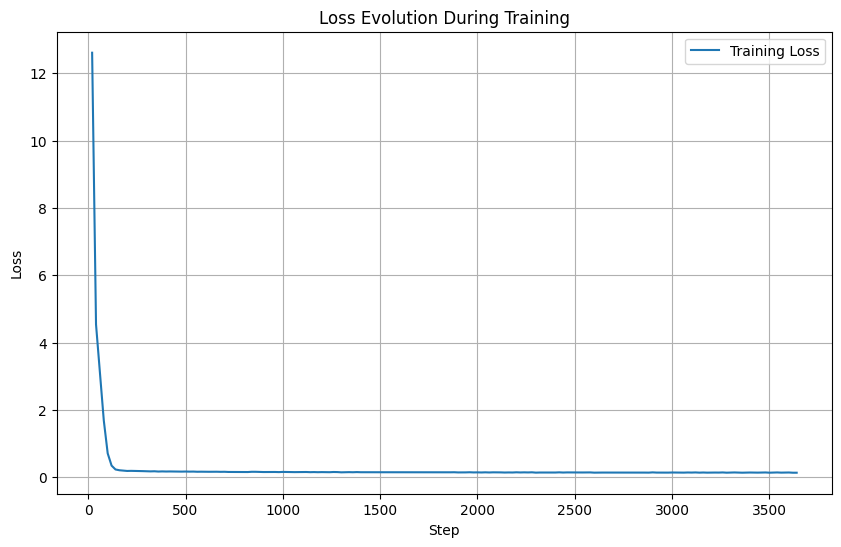

In [ ]:
trainer_t5.train()
loss_tracker_t5.plot_loss()

In [ ]:
#guardar
model_t5.save_pretrained("t5-detox_model")

### Entrenamiento para BART

In [ ]:
#torch.cuda.empty_cache()

training_args_bart = Seq2SeqTrainingArguments(
    output_dir='./checkpoints-bart',
    # evaluation_strategy="no",
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    logging_steps = 20,
    eval_steps=146*5, # cada 5 epochs, teniendo batches de 128
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=2e-4,
    num_train_epochs=25,  # lo maximo intentando no superar el límite de tiempo de google colab
    report_to=["none"], # para no pedir login de 'wandb' y otros
    # fp16=True, # acelera el entrenaminento pero lo empeora
)

loss_tracker_bart = LossTrackerCallback()

trainer_bart = Seq2SeqTrainer(
    model=model_bart,
    args=training_args_bart,
    train_dataset=train_dataset_bart,
    eval_dataset=val_dataset_bart,
     callbacks=[loss_tracker_bart],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer_bart.train()
loss_tracker_bart.plot_loss()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.54 GiB. GPU 0 has a total capacity of 14.75 GiB of which 23.06 MiB is free. Process 3600 has 14.72 GiB memory in use. Of the allocated memory 14.29 GiB is allocated by PyTorch, and 316.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer_bart.predict(test_dataset=test_dataset_bart).metrics

In [ ]:
#guardar
model_bart.save_pretrained("bart-detox_model")

## Prueba del modelo

In [ ]:
#cargar y probar
loaded_model = T5ForConditionalGeneration.from_pretrained("t5-detox_model")
loaded_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [ ]:
def detoxify_sentence(sentence, language, tokenizer):
  print(f"FRASE ORIGINAL: {sentence}")
  translated_sentence = translate(sentence, language, 'en')
  input_ids = tokenizer(translated_sentence, return_tensors="pt").input_ids.to(device)
  outputs = loaded_model.generate(input_ids)
  detoxified_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)
  translated_detoxified_sentence = translate(detoxified_sentence, 'en', language)
  print(f"FRASE DETOXIFICADA: {translated_detoxified_sentence}")
  return translated_detoxified_sentence

In [ ]:
sample = df_total[df_total["source_language"] == 'es'].sample(1)
toxic_sentence = sample['toxic_sentence'].iloc[0]
source_language = sample['source_language'].iloc[0]

detoxify_sentence(toxic_sentence, source_language, tokenizer_t5);

FRASE ORIGINAL: La puta que frustración .
FRASE DETOXIFICADA: La persona, qué problema.


In [ ]:
sample = df_total[df_total["source_language"] == 'en'].sample(1)
toxic_sentence = sample['toxic_sentence'].iloc[0]
source_language = sample['source_language'].iloc[0]

detoxify_sentence(toxic_sentence, source_language, tokenizer_t5);

FRASE ORIGINAL: hamas alone can 't even get their shit together to be 'one side'
FRASE DETOXIFICADA: Hamas alone can't even get their things together to be 'one side'


## Evaluación

Vamos a seguir la misma evaluación usada en PAN. Para esto tendremos que ejecutar el proceso de detoxificación sobre el dataset de test.

Sobre las salidas tendremos que medir 3 variables usando el código proporcionado:
- Style Transfer Accuracy: Medir el nivel de no-toxicidad.
- Content Preservation: Comparar si la frase de salida mantiene el significado de la frase original.
- Fluency: Medir la adecuación del texto y su similaridad a las referencias escritas por humanos.

Estas tres métricas devolverán valores entre 0 y 1. Al multiplicar estos tres valores obtendremos la puntuación global.

El código para estas métricas es proporcionado por PAN.

### Ejecución sobre el conjunto de test

In [ ]:
print(X_test[:1])
print(y_test[:1])
print(X_test_tokens_t5[:1])
print(y_test_tokens_t5[:1])

['i was thinkin the same shit']
['i was thinking the same way']
{'input_ids': tensor([[    3,    23,    47,   317,    77,     8,   337,     3,     7, 10536,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 

In [39]:
loaded_model = T5ForConditionalGeneration.from_pretrained("t5-detox_model")
loaded_model.to(device)
X_test_tokens_t5 = X_test_tokens_t5.to(device)

In [15]:
# Generar predicción
outputs = loaded_model.generate(X_test_tokens_t5["input_ids"])

# Decodificar las predicciones a texto legible
decoded_outputs = tokenizer_t5.batch_decode(outputs, skip_special_tokens=True)

print("Predicciónes del conjuto de test:", decoded_outputs)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicciónes del conjuto de test: ['I was thinkin the same thing', 'sure, see you later', 'citizens keeps voting in the same political party giving the same results over and over again .', 'people woah * * calm * * down sailor .', 'then we wont have to hear from this guy or the transgenders again .', 'This sort of thing happens everywhere in every culture and country.', 'why are a lot of these comments defending this guy ?', 'I want him...for a short time...but this Bavarian is really a', 'This is not true female boxing. True female boxing scolded Gu A', 'Idk all I know is today is Friday', 'Egyptian commentators include beggars, halafites, and shara', 'Maybe blacks should be thankful for their good fortune!', 'Can someone explain to these jurors that the days of free money are over .', 'We are jealous of our sexy tweets', 'No batshit crazy animal rights activists here to complain?', 'He should be beaten mercilessly every day he has left of his miserable life.', 'A lot of my friends fr

In [32]:
# Crea el DataFrame de test
df_test = pd.DataFrame({
    "source_language": list(test['source_language']),
    "X_test": list(test['toxic_sentence']),
    "X_test_en": X_test,
    "y_test_en": y_test,
    "y_test": list(test['neutral_sentence']),
    "y_pred_en": decoded_outputs,
})


In [34]:
df_test.sample(5)

,source_language,X_test,X_test_en,y_test_en,y_test,y_pred_en
2021,ru,"кошмар, руки бы оторвать. придурки .:o","It's a nightmare, I could tear my hands off. a...",terrible!,ужасно!,"It's a nightmare, I could tear my hands off."
642,en,yeah man warm temperatures in a warm environme...,yeah man warm temperatures in a warm environme...,global warming is affecting climate change,global warming is affecting climate change,Yeah man warm temperatures in a warm environme...
1979,en,why should i give a fuck !,why should i give a fuck !,Why do I have to worry?,Why do I have to worry?,Why should I care?
63,en,i flag all that shit .,i flag all that shit .,I flag all that stuff.,I flag all that stuff.,I flag all that stuff.
1512,en,and that is one profoundly fucked up story .,and that is one profoundly fucked up story .,and that is one profoundly bad story .,and that is one profoundly bad story .,And that is one profoundly wrong story.


In [35]:
df_test_numpy = df_test.to_numpy()

prediction_translations = []

for sentence in tqdm(df_test_numpy):
  prediction_translations.append(translate(sentence[3], 'en', sentence[0]))

df_test["y_pred"] = prediction_translations

100%|██████████| 2335/2335 [00:33<00:00, 69.47it/s]


In [36]:
df_test.sample(3)

,source_language,X_test,X_test_en,y_test_en,y_test,y_pred_en,y_pred
1626,en,they won 't but egypt is shit for everybody ri...,they won 't but egypt is shit for everybody ri...,"They won't, but Egypt is not that good for eve...","They won't, but Egypt is not that good for eve...",they won't but egypt is bad for everybody righ...,"They won't, but Egypt is not that good for eve..."
729,ru,"уахаха, сук. чел, ты гений.","wow, bitch. man, you're a genius.","wow man, you are a genius.","уахаха, человек, ты гений.","Wow, you're a genius.","вау чувак, ты гений."
1269,en,u see me mad right n just fuckin talkin like r...,u see me mad right n just fuckin talkin like r...,u see me mad right n just talkin like really t...,u see me mad right n just talkin like really t...,You see me mad right and just talkin like real...,u see me mad right n just talkin like really t...


In [37]:
# Guardar los resultados
df_test["X_test"].to_json("input.jsonl", orient="records", lines=True)
df_test["y_test"].to_json("references.jsonl", orient="records", lines=True)
df_test["y_pred"].to_json("predictions.jsonl", orient="records", lines=True)

### Evaluación

In [40]:
#Eliminar el modelo de detoxificacion para limpiar la memoria
import gc

loaded_model.to('cpu')
del loaded_model
gc.collect()
torch.cuda.empty_cache()

In [72]:


def prepare_target_label(
    model: AutoModelForSequenceClassification, target_label: Union[int, str]
) -> int:
    """
    Prepare the target label to ensure it is valid for the given model.

    Args:
        model (AutoModelForSequenceClassification): Text classification model.
        target_label (Union[int, str]): The target label to prepare.

    Returns:
        int: The prepared target label.

    Raises:
        ValueError: If the target_label is not found in model labels or ids.
    """
    if target_label in model.config.id2label:
        pass
    elif target_label in model.config.label2id:
        target_label = model.config.label2id.get(target_label)
    elif (
        isinstance(target_label, str)
        and target_label.isnumeric()
        and int(target_label) in model.config.id2label
    ):
        target_label = int(target_label)
    else:
        raise ValueError(
            f'target_label "{target_label}" not in model labels or ids: {model.config.id2label}.'
        )
    assert isinstance(target_label, int)
    return target_label

def classify_texts(
    model: AutoModelForSequenceClassification,
    tokenizer: AutoTokenizer,
    texts: List[str],
    target_label: Union[int, str],
    second_texts: Optional[List[str]] = None,
    batch_size: int = 32,
    raw_logits: bool = False,
    desc: Optional[str] = "Calculating STA scores",
) -> npt.NDArray[np.float64]:
    """
    Classify a list of texts using the given model and tokenizer.

    Args:
        model (AutoModelForSequenceClassification): Text classification model.
        tokenizer (AutoTokenizer): The tokenizer corresponding to the model.
        texts (List[str]): List of texts to classify.
        target_label (Union[int, str]): The target label for classification.
        second_texts (Optional[List[str]]): List of secondary texts (not needed by default).
        batch_size (int): Batch size for inference.
        raw_logits (bool): Whether to return raw logits instead of probs.
        desc (Optional[str]): Description for tqdm progress bar.

    Returns:
        npt.NDArray[np.float64]: Array of classification scores for the texts.
    """

    target_label = prepare_target_label(model, target_label)

    res = []

    for i in trange(0, len(texts), batch_size, desc=desc):
        inputs = [texts[i : i + batch_size]]

        if second_texts is not None:
            inputs.append(second_texts[i : i + batch_size])
        inputs = tokenizer(
            *inputs,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
        ).to(model.device)

        with torch.no_grad():
            try:
                logits = model(**inputs).logits
                if raw_logits:
                    preds = logits[:, target_label]
                elif logits.shape[-1] > 1:
                    preds = torch.softmax(logits, -1)[:, target_label]
                else:
                    preds = torch.sigmoid(logits)[:, 0]
                preds = preds.cpu().numpy()
            except:
                print(i, i + batch_size)
                preds = [0] * len(inputs)
        res.append(preds)
    return np.concatenate(res)

def evaluate_sta(
    model: AutoModelForSequenceClassification,
    tokenizer: AutoTokenizer,
    texts: List[str],
    target_label: int = 0,  # 1 is polite, 0 is toxic
    batch_size: int = 32,
) -> npt.NDArray[np.float64]:
    """
    Evaluate the STA of a list of texts using the given model and tokenizer.

    Args:
        model (AutoModelForSequenceClassification): Text classification model.
        tokenizer (AutoTokenizer): The tokenizer corresponding to the model.
        texts (List[str]): List of texts to evaluate.
        target_label (int): The target label for style evaluation.
        batch_size (int): Batch size for inference.

    Returns:
        npt.NDArray[np.float64]: Array of STA scores for the texts.
    """
    target_label = prepare_target_label(model, target_label)
    scores = classify_texts(
        model, tokenizer, texts, target_label, batch_size=batch_size, desc="Style"
    )

    return scores

def evaluate_sim(
    model: SentenceTransformer,
    original_texts: List[str],
    rewritten_texts: List[str],
    batch_size: int = 32,
    efficient_version: bool = False,
) -> npt.NDArray[np.float64]:
    """
    Evaluate the semantic similarity between original and rewritten texts.
    Note that the subtraction is done due to the implementation of the `cosine` metric in `scipy`.
    For more details see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html

    Args:
        model (SentenceTransformer): The sentence transformer model.
        original_texts (List[str]): List of original texts.
        rewritten_texts (List[str]): List of rewritten texts.
        batch_size (int): Batch size for inference.
        efficient_version (bool): To use efficient calculation method.

    Returns:
        npt.NDArray[np.float64]: Array of semantic similarity scores between \
              original and rewritten texts.
    """
    similarities = []

    batch_size = min(batch_size, len(original_texts))
    for i in trange(0, len(original_texts), batch_size, desc="Calculating SIM scores"):
        original_batch = original_texts[i : i + batch_size]
        rewritten_batch = rewritten_texts[i : i + batch_size]

        embeddings = model.encode(original_batch + rewritten_batch)
        original_embeddings = embeddings[: len(original_batch)]
        rewritten_embeddings = embeddings[len(original_batch) :]

        if efficient_version:
            similarity_matrix = np.dot(original_embeddings, rewritten_embeddings.T)
            original_norms = np.linalg.norm(original_embeddings, axis=1)
            rewritten_norms = np.linalg.norm(rewritten_embeddings, axis=1)
            similarities.extend(
                1
                - similarity_matrix / (np.outer(original_norms, rewritten_norms) + 1e-9)
            )
        else:
            t = [
                1 - cosine(original_embedding, rewritten_embedding)
                for original_embedding, rewritten_embedding in zip(
                    original_embeddings, rewritten_embeddings
                )
            ]
            similarities.extend(t)
    return similarities

def evaluate_style_transfer(
    original_texts: List[str],
    rewritten_texts: List[str],
    style_model: AutoModelForSequenceClassification,
    style_tokenizer: AutoTokenizer,
    meaning_model: SentenceTransformer,
    references: Optional[List[str]] = None,
    style_target_label: int = 0,
    batch_size: int = 32,
) -> Dict[str, np.ndarray]:

    accuracy = evaluate_sta(
        style_model,
        style_tokenizer,
        rewritten_texts,
        target_label=style_target_label,
        batch_size=batch_size,
    )

    similarity = evaluate_sim(
        model=meaning_model,
        original_texts=original_texts,
        rewritten_texts=rewritten_texts,
        batch_size=batch_size,
    )

    result = {
        "STA": accuracy,
        "SIM": similarity,
    }

    if references is not None:

        chrf = CHRF()

        result["CHRF"] = np.array(
            [
                chrf.sentence_score(hypothesis=rewritten, references=[reference]).score
                / 100
                for rewritten, reference in zip(rewritten_texts, references)
            ],
            dtype=np.float64,
        )

        result["J"] = result["STA"] * result["SIM"] * result["CHRF"]

    return result


def load_model(
    model_name: Optional[str] = None,
    model_class: Optional[Callable] = None,
    use_cuda: bool = True,
) -> Union[AutoModelForSequenceClassification, SentenceTransformer, AutoTokenizer]:
    if model_name == "sentence-transformers/LaBSE":
        return SentenceTransformer(model_name)
    model = model_class.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if use_cuda and torch.cuda.is_available():
        model.cuda()
    return model, tokenizer

def run_evaluation(
    input_data: pd.DataFrame,
    predictions: pd.DataFrame,
    golden_data: Optional[pd.DataFrame] = None,
    style_model_name: str = "textdetox/xlmr-large-toxicity-classifier",
    meaning_model_name: str = "sentence-transformers/LaBSE",
    style_target_label: int = 0,
    batch_size: int = 32,
    use_cuda: bool = True,
) -> Dict[str, np.ndarray]:
    style_model, style_tokenizer = load_model(
        style_model_name, AutoModelForSequenceClassification, use_cuda=use_cuda
    )
    meaning_model = load_model(meaning_model_name, SentenceTransformer, use_cuda=use_cuda)

    # Prepare data
    input_texts = input_data["input"].tolist()
    prediction_texts = predictions["prediction"].tolist()
    references = golden_data["reference"].tolist() if golden_data is not None else None

    # Run evaluation
    return evaluate_style_transfer(
        original_texts=input_texts,
        rewritten_texts=prediction_texts,
        references=references,
        style_model=style_model,
        style_tokenizer=style_tokenizer,
        meaning_model=meaning_model,
        style_target_label=style_target_label,
        batch_size=batch_size,
    )

In [73]:
df_input = pd.read_json("input.jsonl", lines=True)
df_input.rename(columns={0: "input"}, inplace=True)
df_prediction = pd.read_json("predictions.jsonl", lines=True)
df_prediction.rename(columns={0: "prediction"}, inplace=True)
df_golden = pd.read_json("references.jsonl", lines=True)
df_golden.rename(columns={0: "reference"}, inplace=True)
results = run_evaluation(df_input, df_prediction, golden_data=df_golden)
print(results)

Style:   0%|          | 0/73 [00:00<?, ?it/s]

Calculating SIM scores:   0%|          | 0/73 [00:00<?, ?it/s]

{'STA': array([0.9997199 , 0.9996854 , 0.9996619 , ..., 0.00153588, 0.8772176 ,
       0.99945086], dtype=float32), 'SIM': [0.9035031256971896, 0.8705184045897523, 0.9527056217193604, 0.4609981179237366, 0.7216010093688965, 0.9415757094874572, 0.9468674032013077, 0.8553410172462463, 0.6732548280510215, 0.9684576410974495, 0.5701444149017334, 0.9798957401482986, 0.9684087038040161, 0.84244704246521, 0.903021687449319, 0.3635607361793518, 0.8139681351752435, 0.8816405605292001, 0.9712024348257539, 0.9337350408355908, 0.9644886276430726, 0.7187512516975403, 0.5070714648323387, 0.7751201853227739, 0.95649653673172, 0.9332029183627931, 0.9869619902063014, 0.8772636578836253, 0.7141361662230603, 0.5847213268280029, 0.8758896776339159, 0.6426303386688232, 0.7483260481551928, 0.84006960153165, 0.7874100208282471, 0.6268230303035371, 0.7240445829643188, 0.6668702562710722, 0.883941650390625, 0.8388673759181886, 0.38826075196266174, 0.9818257678643344, 0.9687981605529785, 0.7828607559204102, 0.8

In [74]:
df_test['STA'] = results['STA']
df_test['SIM'] = results['SIM']
df_test['CHRF'] = results['CHRF']
df_test['J'] = results['J']

In [75]:
df_test.sample(5)

,source_language,X_test,X_test_en,y_test_en,y_test,y_pred_en,y_pred,STA,SIM,CHRF,J
2254,en,"god , talk about a shit job .","god , talk about a shit job .",Talk about a bad job.,Talk about a bad job.,"god , talk about a bad job .",Talk about a bad job.,0.998925,0.696039,1.0,0.695291
837,en,i had no vote or voice in electing the people ...,i had no vote or voice in electing the people ...,I had no vote or voice in electing the people ...,I had no vote or voice in electing the people ...,I had no vote or voice in electing the people ...,I had no vote or voice in electing the people ...,0.999591,0.934000,1.0,0.933618
417,en,can we just go back to oos already and be done...,can we just go back to oos already and be done...,can we just go back to oos already and be done...,can we just go back to oos already and be done...,Can you just go back to oos already and be don...,can we just go back to oos already and be done...,0.998772,0.864112,1.0,0.863050
1432,en,butt ass naked jus cuz its hot,butt ass naked jus cuz its hot,naked jus cuz its hot,naked jus cuz its hot,Butt naked jus cuz its hot,naked jus cuz its hot,0.000358,0.893268,1.0,0.000320
339,en,the irs can 't find their own fucking emails .,the irs can 't find their own fucking emails .,The irs can't find their own emails,The irs can't find their own emails,The irs can't find their own emails.,The irs can't find their own emails,0.935063,0.910550,1.0,0.851422


COMBINED AVERAGE SCORE:
0.6748444608800811
--------------------------------------------------


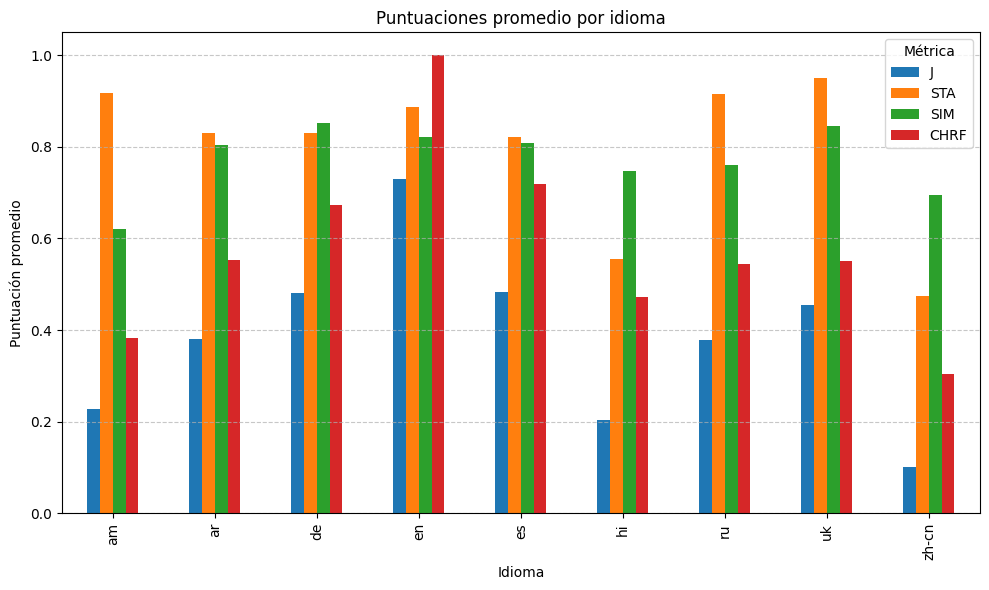

In [76]:
average_leaderboard_score = df_test['J'].mean()
print("COMBINED AVERAGE SCORE:")
print(average_leaderboard_score)
print("-" * 50)

results = {
    'source_language': [],
    'J': [],
    'STA': [],
    'SIM': [],
    'CHRF': []
}

for language in df_test['source_language'].unique():
    results['source_language'].append(language)
    results['J'].append(df_test[df_test['source_language'] == language]['J'].mean())
    results['STA'].append(df_test[df_test['source_language'] == language]['STA'].mean())
    results['SIM'].append(df_test[df_test['source_language'] == language]['SIM'].mean())
    results['CHRF'].append(df_test[df_test['source_language'] == language]['CHRF'].mean())

df_results = pd.DataFrame(results)

grouped = df_results.groupby('source_language')[['J', 'STA', 'SIM', 'CHRF']].mean()

grouped.plot(kind='bar', figsize=(10, 6))

plt.title("Puntuaciones promedio por idioma")
plt.xlabel("Idioma")
plt.ylabel("Puntuación promedio")
plt.legend(title="Métrica")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

## Conclusiones

Viendo el ranking de la competición nuestro resultado habría quedado en novena posición. Podemos ver que el inglés es el idioma donde mejor puntuación obtenemos, debido a que evitamos el proceso de traducción y tenemos una mayor cantidad de datos al usar el dateset extra. Es posible que sin usar este dataset extra, el proceso de entrenamiento hubiese sido peor comparado con usar solo el dataset de la competición, pero hemos hecho todo lo posible por maximizar los resultados.